In [4]:
import cepton_sdk2 as sdk
import cepton_sdk2.utils as util

In [43]:
from typing import List

In [5]:
frames = []
for frame in util.ReadPcap('/home/wlauer/Downloads/X1-1.pcap'):
    frames.append(frame)
    if len(frames) == 30:
        break 
frames = frames[1:]

In [6]:
import matplotlib.pyplot as plt
import numpy as np

In [52]:
def get_sign(frame: sdk.Frame):
    center_channel_id = 32
    s = frame.channel_ids == center_channel_id
    ix = frame.positions[s, 0] / frame.positions[s, 1]
    iz = frame.positions[s, 2] / frame.positions[s, 1]
    azim = np.arctan(ix)
    elev = np.arctan2(iz, np.sqrt((ix ** 2 + 1)))
    x_mu, y_mu = np.mean(azim), np.mean(elev)
    numer = np.sum((azim - x_mu) * (elev - y_mu))
    denom = np.sum((azim - x_mu) ** 2)
    m = numer / denom 
    return np.sign(m)

def show(frame: sdk.Frame):
    center_channel_id = 32
    s = frame.channel_ids == center_channel_id
    ix = frame.positions[s, 0] / frame.positions[s, 1]
    iz = frame.positions[s, 2] / frame.positions[s, 1]
    azim = np.arctan(ix)
    elev = np.arctan2(iz, np.sqrt((ix ** 2 + 1)))


    x_mu, y_mu = np.mean(azim), np.mean(elev)
    numer = np.sum((azim - x_mu) * (elev - y_mu))
    denom = np.sum((azim - x_mu) ** 2)
    m = numer / denom 
    plt.title(np.sign(m))
    plt.gca().set_aspect('equal')
    plt.scatter(azim, elev, c=frame.timestamps[s])
    plt.colorbar()
    plt.show()

def get_start_agg_idx(frames: List[sdk.Frame]):
    """Scan until we get a frame where sign(frame[i]) != sign(frame[i=1]).
    Start accumulating frames at half-frequency from here on, so that every
    pair has a frame with positive sign and a frame with negative sign.
    """
    for i in range(1, len(frames)):
        if get_sign(frames[i]) != get_sign(frames[i-1]):
            return i - 1
    return -1
        

In [53]:
get_start_agg_idx(frames)

1

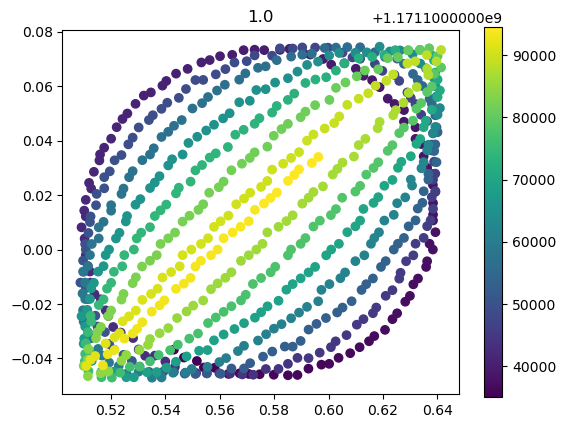

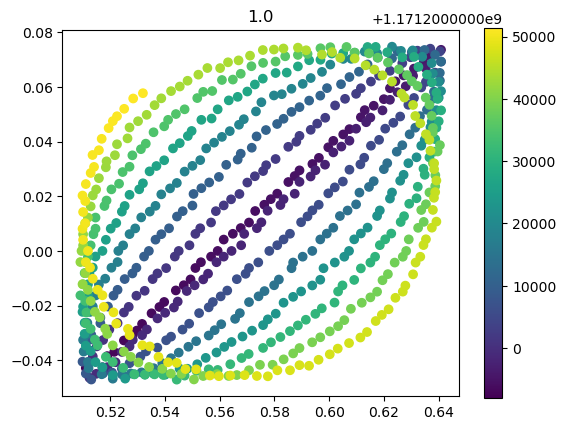

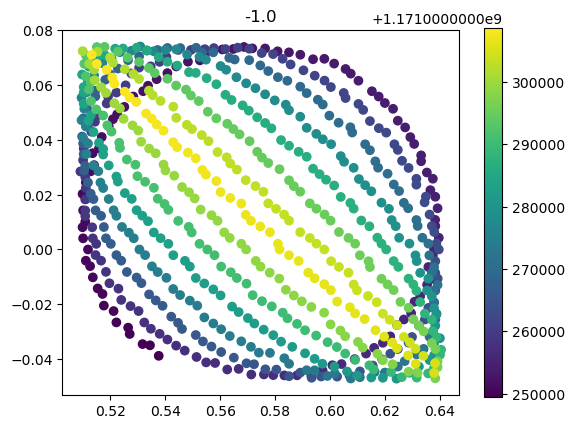

In [54]:
show(frames[0])
show(frames[1])
show(frames[2])

After running the publisher with half-frequency mode, and logging to CSV with the subscriber, verify that the accumulated frames are correct using the following code:

In [36]:
def show_frame_spherical(csv: str):
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    d = pd.read_csv(csv)
    channels = np.array(d.c)
    azim, elev = np.array(d.azimuth)[channels == 0], np.array(d.elevation)[channels == 0]
    print(len(azim))
    plt.gca().set_aspect('equal')
    plt.scatter(azim, elev, s=0.1)
    plt.show()

### Test 1: Spherical Coordinates

Description:
Run the publisher, publishing one of the PCL2 topics.
Run the subscriber, exporting to CSV. 


```
# Terminal 1
ros2 run cepton_publisher cepton_publisher_node --ros-args -p half_frequency_mode:=false -p include_invalid_points:=true -p pcl2_output_type:=SN -p cepx_output_type:=NONE

# Terminal 2
rm -rf frames/
ros2 run cepton_subscriber cepton_subscriber_node --ros-args -p subscribe_pcl2:=true -p export_to_csv:=true
```

Run the following code, it should display one of the subfields correctly.


1590


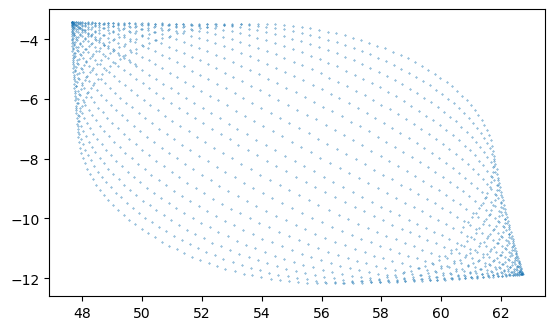

1590


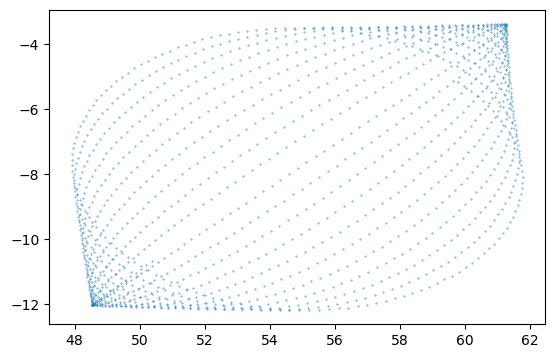

In [48]:
for i in range(1, 3):
    show_frame_spherical(f'/home/wlauer/sdk/ros2/frames/{i}.csv')

### Test 2: Default Frequency Mode

Description:
Run the publisher, publishing one of the PCL2 topics. Do not specity the "half-frequency" flag
Run the subscriber, exporting to CSV. 

Run the following code, it should display one of the subfields, and should have only an individual lissajous frame


```
# Terminal 1
ros2 run cepton_publisher cepton_publisher_node --ros-args -p half_frequency_mode:=false -p include_invalid_points:=true -p pcl2_output_type:=SN -p cepx_output_type:=NONE

# Terminal 2
rm -rf frames/
ros2 run cepton_subscriber cepton_subscriber_node --ros-args -p subscribe_pcl2:=true -p export_to_csv:=true
```

1590


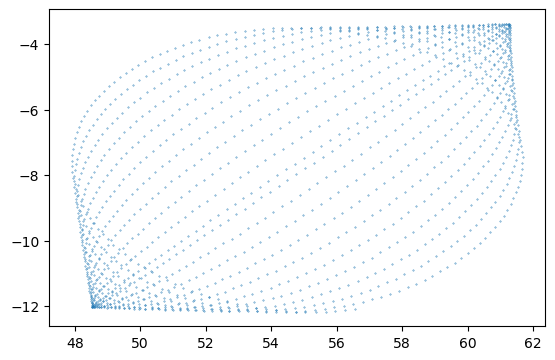

1590


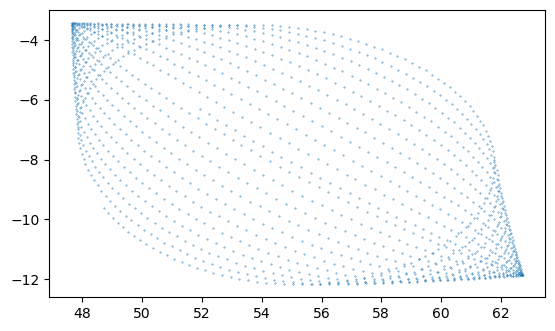

In [49]:
for i in range(1, 3):
    show_frame_spherical(f'/home/wlauer/sdk/ros2/frames/{i}.csv')

### Test 3: ROS2 Half Frequency Mode

Description:
Run the publisher, publishing one of the PCL2 topics. This time, do specity the "half-frequency" flag
Run the subscriber, exporting to CSV. 

Run the following code, it should display one of the subfields, and should show two merged frames with opposing scan directions


```
# Terminal 1
ros2 run cepton_publisher cepton_publisher_node --ros-args -p half_frequency_mode:=true -p include_invalid_points:=true -p pcl2_output_type:=SN -p cepx_output_type:=NONE

# Terminal 2
rm -rf frames/
ros2 run cepton_subscriber cepton_subscriber_node --ros-args -p subscribe_pcl2:=true -p export_to_csv:=true
```


3181


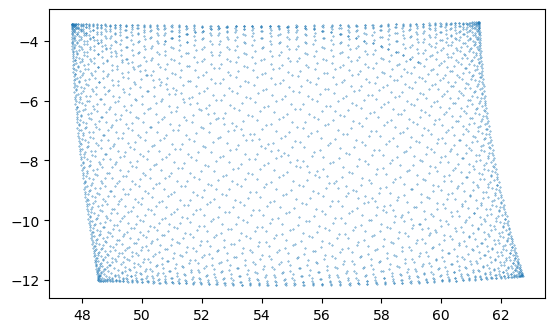

3180


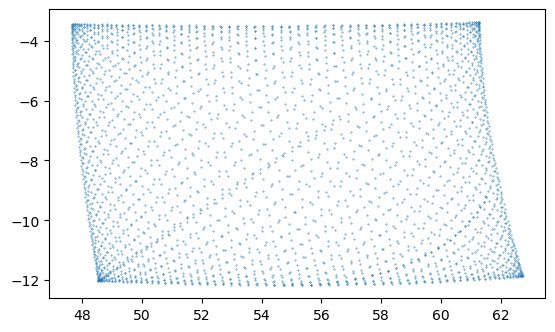

In [50]:
for i in range(1, 3):
    show_frame_spherical(f'/home/wlauer/sdk/ros2/frames/{i}.csv')

### Test 4: Timed Frame Mode

Description:
Run the publisher, publishing one of the PCL2 topics. Set the frame time to be something small, like 20000 microseconds.
Run the subscriber, exporting to CSV. 


```
# Terminal 1
ros2 run cepton_publisher cepton_publisher_node --ros-args -p aggregation_mode:=20000 -p include_invalid_points:=true -p pcl2_output_type:=SN -p cepx_output_type:=NONE

# Terminal 2
rm -rf frames/
ros2 run cepton_subscriber cepton_subscriber_node --ros-args -p subscribe_pcl2:=true -p export_to_csv:=true
```

Run the following code, it should display a partial scan.


361


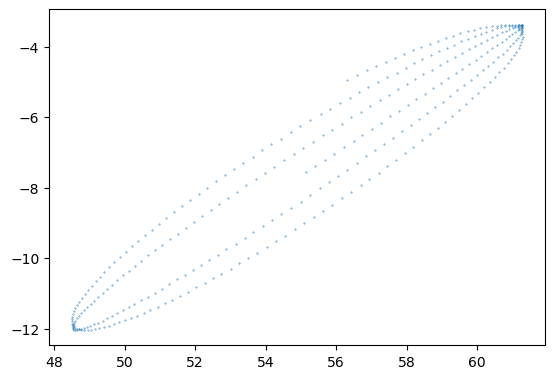

362


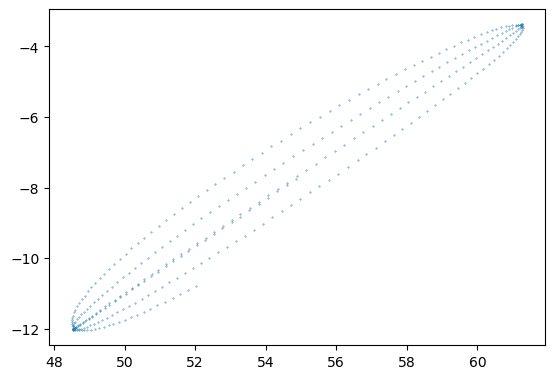

In [53]:
for i in range(1, 3):
    show_frame_spherical(f'/home/wlauer/sdk/ros2/frames/{i}.csv')

### Test 5: Timed Frame Mode (Complete Scan)

Description:
Run the publisher, publishing one of the PCL2 topics. Set the frame time to be something close to the actual frame rate, like 100k microseconds.
Run the subscriber, exporting to CSV. 


```
# Terminal 1
ros2 run cepton_publisher cepton_publisher_node --ros-args -p aggregation_mode:=100000 -p include_invalid_points:=true -p pcl2_output_type:=SN -p cepx_output_type:=NONE

# Terminal 2
rm -rf frames/
ros2 run cepton_subscriber cepton_subscriber_node --ros-args -p subscribe_pcl2:=true -p export_to_csv:=true
```

Run the following code, it should display a more-complete scan

1806


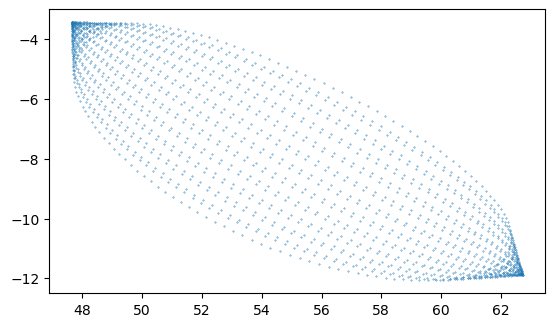

1806


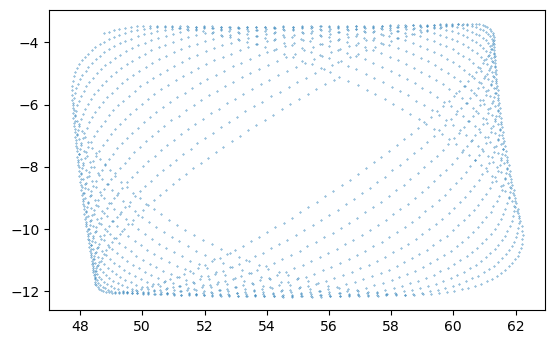

In [55]:
for i in range(1, 3):
    show_frame_spherical(f'/home/wlauer/sdk/ros2/frames/{i}.csv')

### Test 6: ROS2 Sensor Time Out Status

Description: This is testing that a status message gets published when a sensor is disconnected.


- Run the following, with the sensor unplugged:
```
# Terminal 1:
ros2 run cepton_publisher cepton_publisher_node --ros-args -p aggregation_mode:=100000 -p include_invalid_points:=true -p pcl2_output_type:=SN -p cepx_output_type:=NONE

# Terminal 2
ros2 topic echo cepton_sensor_status
```

- There should be nothing showing up in terminal 2. 

- Then plug in a sensor. Still nothing should show up in terminal 2.

- Unplug the sensor. After a couple of seconds, some error messages should start showing up in terminal 2. 

- Plug the sensor back in. The error messages should stop being reported.


In [2]:
import getpass 
user = getpass.getuser()

Building for ROS1 tests:
```
catkin_make
source ./devel/setup.bash
```

### Test 1: ROS1 Spherical Coordinates

Description:
Run the publisher, publishing one of the PCL2 topics.
Run the subscriber, exporting to CSV. 


```
# Terminal 1
roslaunch cepton2_ros manager.launch


# Terminal 1
roslaunch cepton2_ros publisher.launch config_path:=/home/cepton/sdk/ros2/notebooks/ros1_test/test1.yaml

# Terminal 2
rm -rf frames/

```

Run the following code, it should display one of the subfields correctly.

In [ ]:
for i in range(1, 3):
    show_frame_spherical(f'/home/{user}/catkin_ws/frames/{i}.csv')

### Test 2: ROS1 Default Frequency Mode

Description:
Run the publisher, publishing one of the PCL2 topics. Do not specity the "half-frequency" flag
Run the subscriber, exporting to CSV. 

Run the following code, it should display one of the subfields, and should have only an individual lissajous frame


```
# Terminal 1
roslaunch cepton2_ros manager.launch


# Terminal 1
roslaunch cepton2_ros publisher.launch config_path:=/home/cepton/sdk/ros2/notebooks/ros1_test/test2.yaml

# Terminal 2
rm -rf frames/

```

In [ ]:
for i in range(1, 3):
    show_frame_spherical(f'/home/{user}/catkin_ws/frames/{i}.csv')

### Test 3: ROS1 Half Frequency Mode

Description:
Run the publisher, publishing one of the PCL2 topics. This time, do specity the "half-frequency" flag
Run the subscriber, exporting to CSV. 

Run the following code, it should display one of the subfields, and should show two merged frames with opposing scan directions


```
# Terminal 1
roslaunch cepton2_ros manager.launch


# Terminal 1
roslaunch cepton2_ros publisher.launch config_path:=/home/cepton/sdk/ros2/notebooks/ros1_test/test3.yaml

# Terminal 2
rm -rf frames/

```


In [ ]:
for i in range(1, 3):
    show_frame_spherical(f'/home/{user}/catkin_ws/frames/{i}.csv')

### Test 4: ROS1 Timed Frame Mode

Description:
Run the publisher, publishing one of the PCL2 topics. Set the frame time to be something small, like 20000 microseconds.
Run the subscriber, exporting to CSV. 


```
# Terminal 1
roslaunch cepton2_ros manager.launch


# Terminal 1
roslaunch cepton2_ros publisher.launch config_path:=/home/cepton/sdk/ros2/notebooks/ros1_test/test4.yaml

# Terminal 2
rm -rf frames/

```

Run the following code, it should display a partial scan.


In [ ]:
for i in range(1, 3):
    show_frame_spherical(f'/home/{user}/catkin_ws/frames/{i}.csv')

### Test 5: ROS1 Timed Frame Mode (Complete Scan)

Description:
Run the publisher, publishing one of the PCL2 topics. Set the frame time to be something close to the actual frame rate, like 100k microseconds.
Run the subscriber, exporting to CSV. 


```
# Terminal 1
roslaunch cepton2_ros manager.launch


# Terminal 1
roslaunch cepton2_ros publisher.launch config_path:=/home/cepton/sdk/ros2/notebooks/ros1_test/test5.yaml

# Terminal 2
rm -rf frames/

```

Run the following code, it should display a more-complete scan

In [ ]:
for i in range(1, 3):
    show_frame_spherical(f'/home/{user}/catkin_ws/frames/{i}.csv')

### Test 6: ROS1 Sensor Time Out Status

Description: This is testing that a status message gets published when a sensor is disconnected.


- Run the following, with the sensor unplugged:
```
# Terminal 1
roslaunch cepton2_ros manager.launch


# Terminal 1
roslaunch cepton2_ros publisher.launch config_path:=/home/cepton/sdk/ros2/notebooks/ros1_test/test6.yaml

# Terminal 2
rm -rf frames/

```

- There should be nothing showing up in terminal 2. 

- Then plug in a sensor. Still nothing should show up in terminal 2.

- Unplug the sensor. After a couple of seconds, some error messages should start showing up in terminal 2. 

- Plug the sensor back in. The error messages should stop being reported.

In [ ]:
for i in range(1, 3):
    show_frame_spherical(f'/home/{user}/catkin_ws/frames/{i}.csv')